In [1]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import asfarray
from numba import jit, float64, prange
import numba

Implement Nelder-Mead method for the Mishra’s Bird function

$$ f(x, y) = \sin(y)e^{(1−\cos(x))^2} + \cos(x)e^{(1−\sin(y))^2} + (x − y)^2 $$

1. To illustrate the behavior of the methods plot simplex (triangle) for every iteration. Provide
the link to code repository.
2. Demonstrate that the algorithm may converge to 
different points depending on the starting
point. Report explicitly two distinct starting 
points x0 and the corresponding $x^∗$
3. Examine the behavior of the method for various 
parameters α, β and γ. For one chosen $x_0$
show that the method may converge to different points.
 Report parameter values and x∗. 

In [2]:
@jit(nogil=True, nopython=True)
def mishra_bird(x, multmax = 10):
    """
    Compute values for Mishra bird function
    Args:
        x: 2d ndarray or list

    Returns:
        Float
    """
    if bound_function(x):
        mult_term = 1
    else:
        mult_term = multmax
    return (np.sin(x[1]) * np.exp((1 - np.cos(x[0]))**2) 
            + np.cos(x[0]) * np.exp((1 - np.sin(x[1]))**2) 
            + (x[0] - x[1])**2) * mult_term

@jit(nogil=True, nopython=True)
def bound_function(x):
    """
    Computes if bound condition satisfied.
    Args:
        x: 2d ndarray or list

    Returns:
        True if bound condition satisfied
        False if point is outside bound condition
    """
    if (x[0] + 5)**2 + (x[1] + 5)**2 < 25:
        return True
    else:
        return False

In [3]:
def wrap_function(function, args):
    ncalls = [0]
    if function is None:
        return ncalls, None

# @jit(nogil=True, nopython=True)
def minimize_neldermead(func, x0,
                        maxiter=400, sim=None,
                        alpha=1, beta=2, gamma=0.5, sigma=0.5,
                         xatol=1e-4, fatol=1e-4):
    

    nonzdelt = 0.05
    zdelt = 0.00025

    x0 = asfarray(x0).flatten()
    
    # Create simplex
    N = len(x0)
    
    if sim is None:
        sim = np.zeros((N + 1, N), dtype=x0.dtype)
        sim[0] = x0
    # Generating simplex points
    # Generate them outside?
    for k in range(N):
        y = np.array(x0, copy=True)
        if y[k] != 0:
            y[k] = (1 + nonzdelt)*y[k]
        else:
            y[k] = zdelt
        sim[k + 1] = y

    allvecs = [sim,]

    one2np1 = list(range(1, N + 1))
    fsim = np.zeros((N + 1,), float)

    for k in range(N + 1):
        fsim[k] = func(sim[k])

    ind = np.argsort(fsim)
    fsim = np.take(fsim, ind, 0)
    # sort so sim[0,:] has the lowest function value
    sim = np.take(sim, ind, 0)

    iterations = 1

    while (iterations < maxiter):
        # If distance between coordinates less than xatol
        # and difference between function values is less than fatol
        if (np.max(np.ravel(np.abs(sim[1:] - sim[0]))) <= xatol and
                np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
            break
        # xbar - center of gravity without worst point
        x_c = np.add.reduce(sim[:-1],0) / N
        # xr - Reflection.
        # sim[-1] - highest value
        x_r =  x_c + alpha * (x_c - sim[-1])
        fxr = func(x_r)
        doshrink = 0
        # If new point xr is better than lowest value
        if fxr < fsim[0]:
            # Expansion case 4a
            x_e = x_c + gamma *( x_r - x_c )
            fxe = func(x_e)

            if fxe < fxr:
                sim[-1] = x_e
                fsim[-1] = fxe
            else:
                sim[-1] = x_r
                fsim[-1] = fxr
        else:  # fsim[0] <= fxr 4b
            if fxr < fsim[-2]:
                sim[-1] = x_r
                fsim[-1] = fxr
            else:  # fxr >= fsim[-2] 4c
                # Perform contraction
                if fxr < fsim[-1]:
                    x_s = x_c + beta * (sim[-1] - x_c)
                    fxs = func(x_s)

                    if fxs <= fxr:
                        sim[-1] = x_s
                        fsim[-1] = fxs
                    else:
                        doshrink = 1
                else:  # 4d
                    # Perform an inside contraction
                    x_ss = x_c + beta * (sim[-1] - x_c)
                    fxss = func(x_ss)

                    if fxss < fsim[-1]:  # 6
                        sim[-1] = x_ss
                        fsim[-1] = fxss
                    else:
                        doshrink = 1

                if doshrink:  # 5
                    for j in one2np1:
                        sim[j] = sim[0] + sigma * (sim[j] - sim[0])
                        fsim[j] = func(sim[j])

        ind = np.argsort(fsim)
        sim = np.take(sim,ind,0)
        fsim = np.take(fsim,ind,0)
        iterations += 1
        allvecs.append(sim)

    x = sim[0]
    fval = np.min(fsim)
    warnflag = 0

    

    # result = OptimizeResult(fun=fval, nit=iterations, nfev=fcalls[0],
    #                         status=warnflag, success=(warnflag == 0),
    #                         x=x, final_simplex=(sim, fsim))
    # if retall:
    #     result['allvecs'] = allvecs
    # return result
    return x, allvecs

In [4]:
x = np.linspace(-10, 0, 100)
y = np.linspace(-10, 0, 100)

X, Y = np.meshgrid(x, y)

In [5]:
@jit(nogil=True, nopython=True, parallel=True)
def compute_mesh(X, Y, multmax=1):
    Z = np.zeros(X.shape)
    for row_id in prange(X.shape[0]):
        for column_id in prange(X.shape[1]):
            Z[row_id, column_id] = mishra_bird(np.array([X[row_id, column_id], 
                                                         Y[row_id, column_id]]), multmax=multmax)
    return Z
        


In [6]:
Z_raw = compute_mesh(X, Y, 1)
Z_bound_cond = compute_mesh(X, Y, 10)

## 3.1
Method illustration. With triangles


In [7]:
found_min, all_simplex = minimize_neldermead(mishra_bird, np.array([-2.0,-9.0]),
                                maxiter=400, sim=None,
                                alpha=1, beta=0.5,
                                xatol=1e-4, fatol=1e-4)
print(found_min, len(all_simplex), all_simplex[0].shape)


[-3.17573529 -7.81985767] 52 (3, 2)


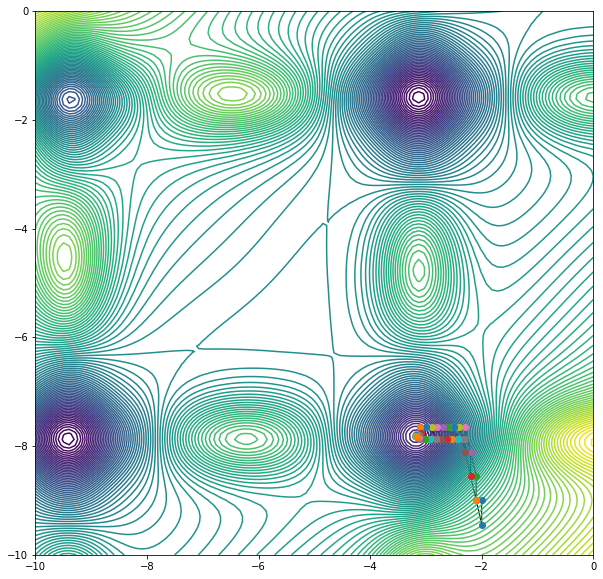

In [8]:
plt.figure(figsize=(10,10))
plt.contour(X, Y, Z_raw, 100)
for simplex in all_simplex: 
    plt.plot(simplex[:,0], simplex[:,1], 'o')
    t1 = plt.Polygon(simplex, fill=False)
    plt.gca().add_patch(t1)

## 3.2

Different starting points:
1. [-8,-6]
2. [-8, -3]
3. [-9, -2]
4. [-2, -9]


In [9]:
found_min_1, all_simplex_1 = minimize_neldermead(mishra_bird, np.array([-8.0,-6.0]),
                                maxiter=400, sim=None,
                                alpha=1, beta=0.5,
                                xatol=1e-4, fatol=1e-4)

found_min_2, all_simplex_2 = minimize_neldermead(mishra_bird, np.array([-8.0,-3.0]),
                                maxiter=400, sim=None,
                                alpha=1, beta=0.5,
                                xatol=1e-4, fatol=1e-4)

found_min_3, all_simplex_3 = minimize_neldermead(mishra_bird, np.array([-9.0,-2.0]),
                                maxiter=400, sim=None,
                                alpha=1, beta=0.5,
                                xatol=1e-4, fatol=1e-4)

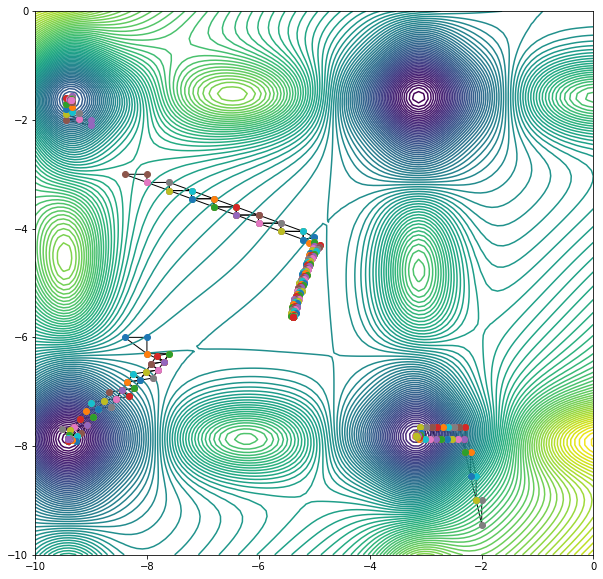

In [10]:

plt.figure(figsize=(10,10))
plt.contour(X, Y, Z_raw, 100)
for simplex_coll in [all_simplex_1, all_simplex_2, all_simplex_3, all_simplex]:
    for simplex in simplex_coll: 
        plt.plot(simplex[:,0], simplex[:,1], 'o')
        t1 = plt.Polygon(simplex, fill=False)
        plt.gca().add_patch(t1)
        

In [11]:
for i, buf_min in enumerate([found_min, found_min_1, found_min_2, found_min_3]):
    print("point #", i+1, " :",  buf_min)

point # 1  : [-3.17573529 -7.81985767]
point # 2  : [-9.41343774 -7.86526144]
point # 3  : [-5.37769192 -5.61789696]
point # 4  : [-9.36757427 -1.62807718]


## 3.3

initial point:  [-8. -3.] 	 found min:  [-4.94328125 -4.23433594] 	 alpha, beta, gamma: 1 2 0.1
initial point:  [-8. -3.] 	 found min:  [-4.94328125 -4.23433594] 	 alpha, beta, gamma: 1 4 0.1
initial point:  [-8. -3.] 	 found min:  [-4.94328125 -4.23433594] 	 alpha, beta, gamma: 1 8 0.1
initial point:  [-8. -3.] 	 found min:  [-5.37468238 -5.60998867] 	 alpha, beta, gamma: 1 2 0.5
initial point:  [-8. -3.] 	 found min:  [-5.37468238 -5.60998867] 	 alpha, beta, gamma: 1 4 0.5
initial point:  [-8. -3.] 	 found min:  [-5.37468238 -5.60998867] 	 alpha, beta, gamma: 1 8 0.5
initial point:  [-8. -3.] 	 found min:  [-5.37695312 -5.61591797] 	 alpha, beta, gamma: 1 2 1
initial point:  [-8. -3.] 	 found min:  [-5.37695312 -5.61591797] 	 alpha, beta, gamma: 1 4 1
initial point:  [-8. -3.] 	 found min:  [-5.37695312 -5.61591797] 	 alpha, beta, gamma: 1 8 1
initial point:  [-8. -3.] 	 found min:  [-5.37768603 -5.61786385] 	 alpha, beta, gamma: 2 2 0.1
initial point:  [-8. -3.] 	 found min:  [-10.2

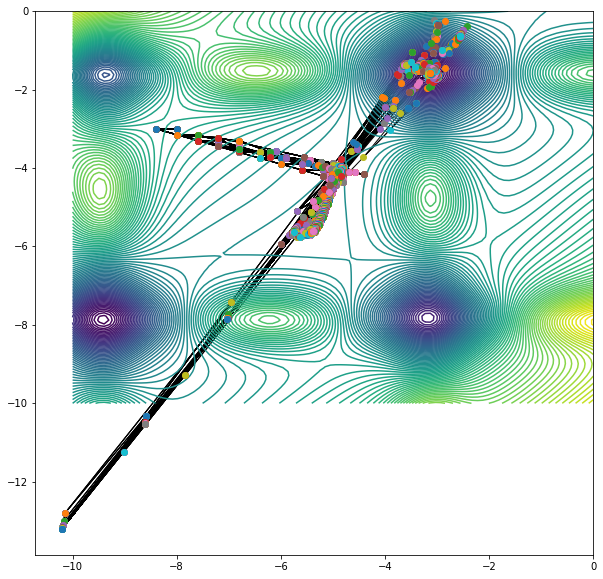

In [12]:
alpha_list = [1,2,3]
gamma_list = [0.1, 0.5, 1]
beta_list = [2, 4, 8]
initial_point = np.array([-8.0,-3.0])
plt.figure(figsize=(10,10))
plt.contour(X, Y, Z_raw, 100)
for alpha in alpha_list:
    for gamma in gamma_list:
        for beta in beta_list:
            found_min_buf, all_simplex_buf = minimize_neldermead(mishra_bird, initial_point,
                                            maxiter=400, sim=None,
                                            alpha=alpha, beta=beta, gamma=gamma,
                                            xatol=1e-4, fatol=1e-4)
            print("initial point: ", initial_point, "\t found min: ", found_min_buf, 
                  "\t alpha, beta, gamma:", alpha, beta, gamma)
            for simplex in all_simplex_buf:
                plt.plot(simplex[:,0], simplex[:,1], 'o')
                t1 = plt.Polygon(simplex, fill=False)
                plt.gca().add_patch(t1)


## 4

In [22]:
def coord_descend(func, x0, alpha=[0.5,0.5], gamma=0.01, maxit=400):
    iterations = 0
    alpha = np.array(alpha)
    gamma = np.array(gamma)
    x_curr = x0.copy()
    history_x = np.zeros([maxit, x0.shape[0]])
    while (iterations < maxit):
        history_x[iterations,:] = x_curr.copy()
        coord_to_minimize = np.mod(iterations, 2)
        s = np.zeros(2)
        s_m = s.copy()
        s_m[coord_to_minimize] = s_m[coord_to_minimize] + alpha[coord_to_minimize]
        s_p = s.copy()
        s_m[coord_to_minimize] = s_m[coord_to_minimize] -alpha[coord_to_minimize]
        f_grad = func(s_p) - func(s_m)
        x_curr[coord_to_minimize] = x_curr[coord_to_minimize] -alpha[coord_to_minimize] * f_grad
        iterations += 1
    return x_curr, history_x

In [23]:
x_initial = np.array([-2,-8])
aplha_coeffs = np.array([0.1,0.1])
x_descend, descent_trace = coord_descend(mishra_bird, x0=x_initial, alpha=np.array([0.1,0.1]))
print(x_descend)

[-2 -8]


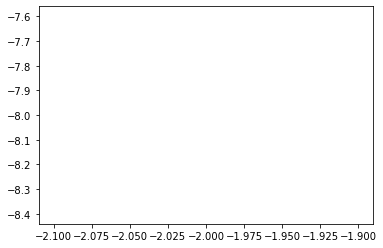

In [24]:
plt.figure()
plt.plot(descent_trace[:,0], descent_trace[:,1])

In [21]:

descent_trace

array([[-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2.